In [1]:
%matplotlib inline

import re

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from sampled import sampled
import scipy.stats as st
plt.style.use('seaborn-talk')
from load_data import make_north_carolina_data, get_nc_map_data
from inference import run_ecological_inference
from plots import plot_nc_map_data

/home/colin/miniconda3/envs/election_data3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = make_north_carolina_data()

In [3]:
nc = get_nc_map_data(data)
congressional = nc.dissolve('district')

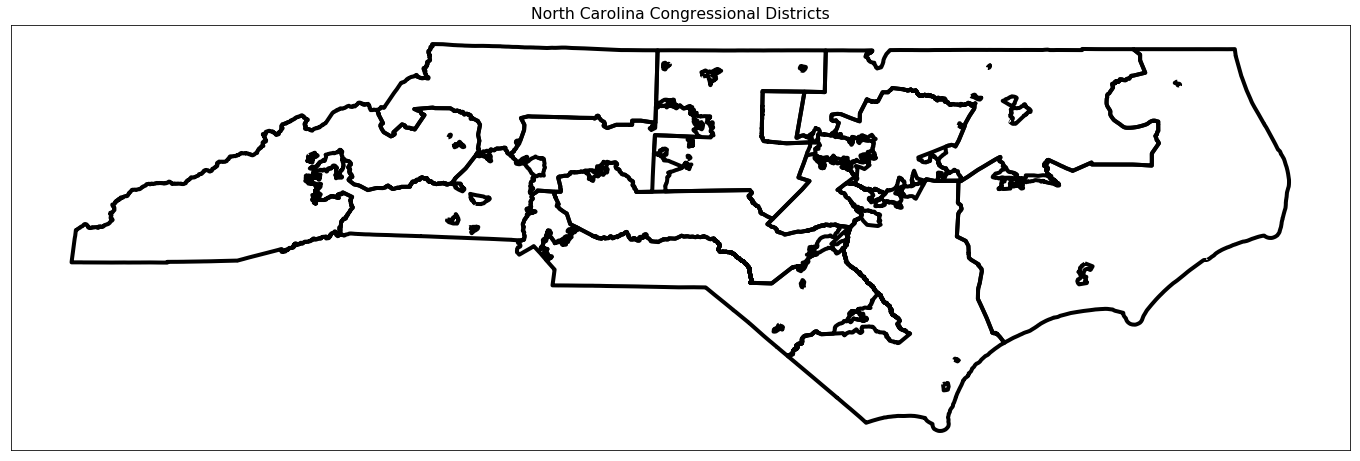

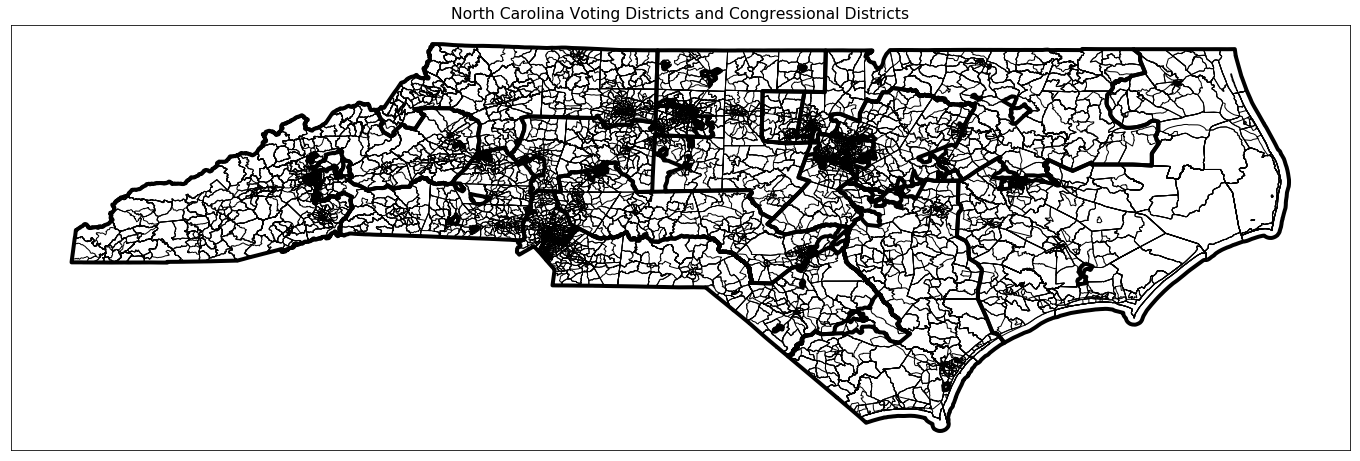

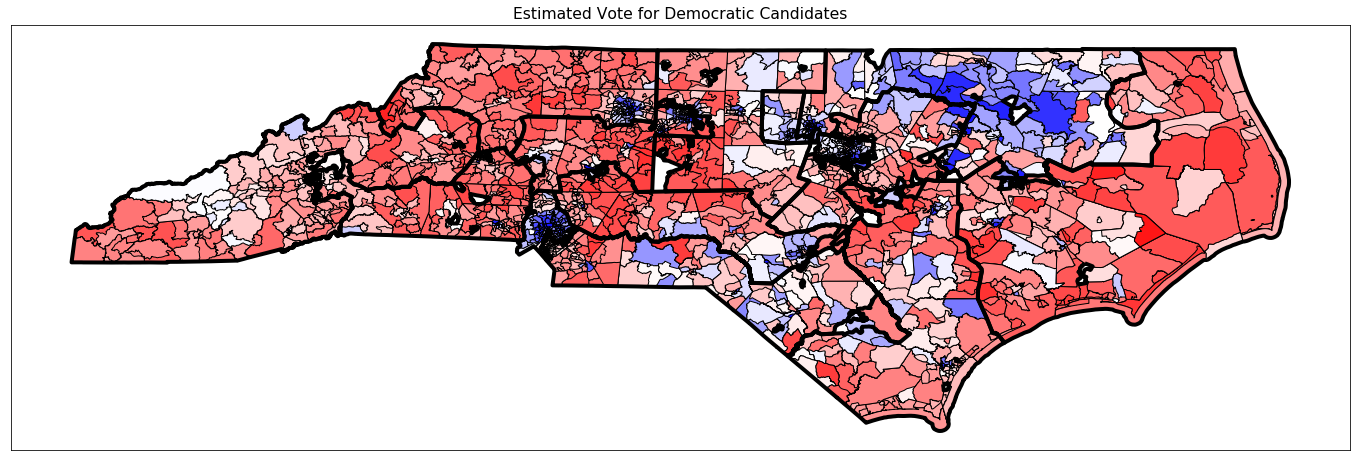

In [4]:
for step in range(3):
    ax = plot_nc_map_data('pct_dem', nc, congressional, '', step=step);
    fig = ax.get_figure()
    fig.savefig('nc_map_{}.png'.format(step), dpi=600, transparent=True, bbox_inches='tight');

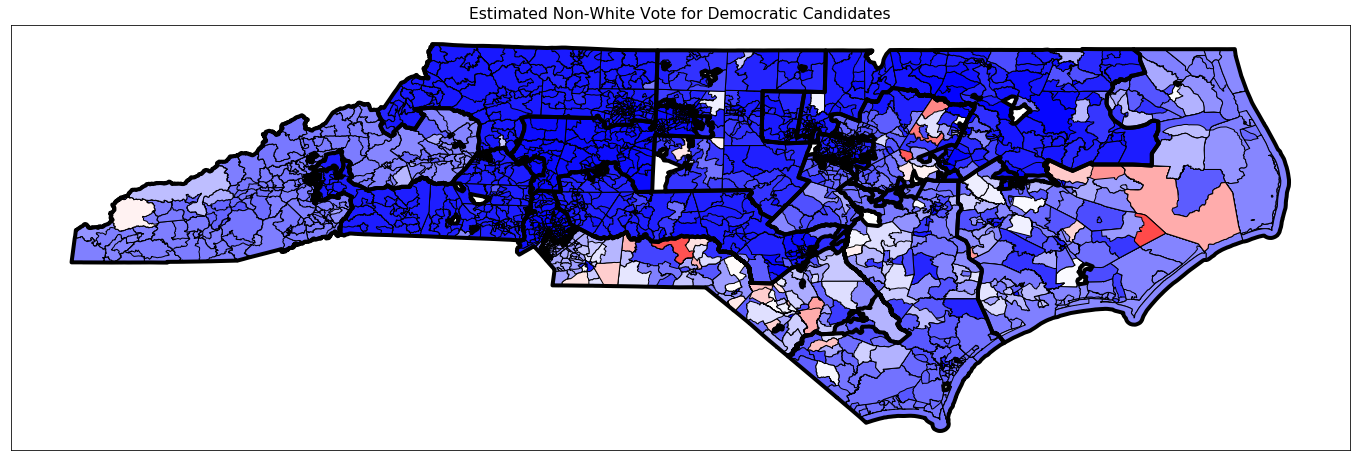

In [5]:
ax = plot_nc_map_data('minority_dem', nc, congressional, 'Non-White ');
fig = ax.get_figure()
fig.savefig('nc_map_non_white.png', dpi=600, transparent=True, bbox_inches='tight');

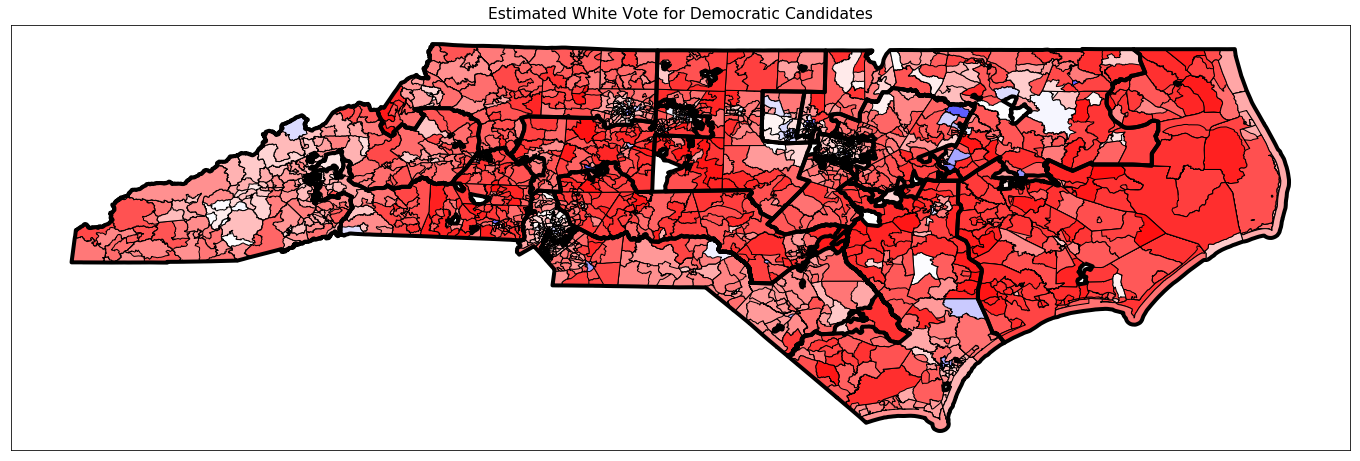

In [6]:
ax = plot_nc_map_data('majority_dem', nc, congressional, 'White ');
fig = ax.get_figure()
fig.savefig('nc_map_white.png', dpi=600, transparent=True, bbox_inches='tight');

In [ ]:
fig = ax.get_figure()
fig.savefig('nc_map.png', dpi=600, transparent=True, bbox_inches='tight');

In [ ]:
district = 13

In [10]:
import glob
for district in range(1, 14):
    print(district)
    district_df = data[data.district==district]
    if glob.glob('*_{}.npy'.format(district)):
        trace = {}
        for var in ('pct_minority_voting_dem', 'pct_majority_voting_dem'):
            trace[var] = np.load('{}_{}.npy'.format(var, district))
    else:
        trace = run_ecological_inference(district_df)
        for var_name in [v for v in trace.varnames if not pm.util.is_transformed_name(v)]:
            np.save('{}_{}.npy'.format(var_name, district), trace[var_name])
    data.loc[district_df.index, 'minority_dem'] = np.mean(trace['pct_minority_voting_dem'], axis=0)
    data.loc[district_df.index, 'majority_dem'] = np.mean(trace['pct_majority_voting_dem'], axis=0)
    data.to_msgpack('inferred_data.mpack')

1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
ax = nc.plot(column='minority_dem', cmap='bwr_r', figsize=(24, 18), edgecolor='black', linewidth=1, vmin=0., vmax=1.)
ax = congressional.plot(ax=ax, facecolor='none', linewidth=4, edgecolor='black')
#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0., 0.12, 0.2, 0.2))
#leg.set_title('Estimated Pct. Vote')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_title('Estimated Non-White Vote for Democratic Candidates');


In [ ]:
fig = ax.get_figure()
fig.savefig('minority_map.png', dpi=600, transparent=True, bbox_inches='tight');

In [ ]:
ax = nc.plot(column='majority_dem', cmap='bwr_r', figsize=(24, 18), edgecolor='black', linewidth=1, vmin=0., vmax=1.)
ax = congressional.plot(ax=ax, facecolor='none', linewidth=4, edgecolor='black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_title('Estimated White Vote for Democratic Candidates');

In [ ]:
fig = ax.get_figure()
fig.savefig('majority_map.png', dpi=600, transparent=True, bbox_inches='tight');

In [ ]:
def plot_rows(trace, district_df, n_rows, district):
    #test = 1.
    #while test > 0.14:
    idxs = np.random.choice(np.arange(len(district_df.label)), n_rows) 
    minority = trace['pct_minority_voting_dem'][:, idxs]
    majority = trace['pct_majority_voting_dem'][:, idxs]
    test = np.std(minority)
    labels = district_df.label.iloc[idxs].values
        #test = np.std(minority, axis=0).mean()
    return plot_precincts(minority, majority, labels, district)


def plot_precincts(minority_pct, majority_pct, y_labels, district, n_x_pts=500):
    N = minority_pct.shape[1]
    fig, ax = plt.subplots(figsize=(12, N // 2))
    x = np.linspace(0, 1, n_x_pts)

    N = minority_pct.shape[1]
    if y_labels is None:
        y_labels = range(N)

    iterator = zip(
        y_labels,
        minority_pct.T, 
        majority_pct.T, 
    )

    mult = 1.3  # controls overlap

    for idx, (precinct, minority, majority) in enumerate(iterator, 1):
        pfx = '' if idx == 1 else '_'
        minority_kde = st.gaussian_kde(minority)
        majority_kde = st.gaussian_kde(majority)
        ax.plot([0], [precinct]);
        trans = ax.convert_yunits(precinct)

        minority_y = minority_kde(x)
        minority_y = mult * minority_y / minority_y.max()
        majority_y = majority_kde(x)
        majority_y = mult * majority_y / majority_y.max()

        fill_1 = ax.fill_between(x, minority_y + trans, trans, color='steelblue', zorder=4*N-4*idx, label=pfx + 'Minority')
        ax.plot(x, minority_y + trans, color='black', linewidth=4, zorder=4*N-4*idx+1)

        fill_2 = ax.fill_between(x, majority_y + trans, trans, color='salmon', zorder=4*N-4*idx+2, label=pfx + 'Majority')
        ax.plot(x, majority_y + trans, color='black', linewidth=4, zorder=4*N-4*idx+3)

    ax.set_title('Inferring majority and minority bloc voting in North Carolina {}'.format(district))
    ax.set_xlabel('Pct vote for democrat')
    ax.legend()
    return fig, ax

In [ ]:
fig, ax = plot_rows(trace, district_df, 15, district);

In [ ]:
data.head()

In [ ]:
fig.savefig('nc{}.png'.format(district), dpi=600, transparent=True, bbox_inches='tight');

In [ ]:
district_df.Total.sum()

In [ ]:
district_df['White Alone'].sum() / district_df.Total.sum()